# Relaxtion EM

This jupyter notebook will demonstrate the Relaxtion method for solving Laplace's equation and compare to a physically informed neural network approach using PyTorch. The goal is to create an animation of the two methods side by side starting from the same random initialization.

We will begin by validating the relaxation method

#### For this problem, we will solve the Laplace Equation(1) for boundary conditions given along: $\{(x=0,y),(x,y=0),(x=GRIDSIZE,y),(x,y=GRIDSIZE)\}$

## $$ \begin{equation} \nabla^2 \Phi = 0 \end{equation}$$

In [39]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

In [104]:
#Variables
GRIDSIZE = 100
DEVICE = 'cpu' #choose 'cpu' or 'cuda' if Pytorch with nvidia is installed


In [105]:
x_dim = np.linspace(0,GRIDSIZE,GRIDSIZE)
y_dim = np.linspace(0,GRIDSIZE,GRIDSIZE)

#initialize our grid
grid = np.meshgrid(x_dim,y_dim)[0]

In [238]:
# For now, lets use sin, cos, and constants as our boundary conditions.
# We should be able to make this anything we want.

#WARNING this currently has an inconsistency in the corners, through for relaxation that shouldn't matter.
# ...for the PINN it should super matter; since we would be attempting to enforce a singular function onto our NN.
# which would be BAD!
def x_0_boundary(x,y):
    return 5*np.cos(np.pi*2*y*3/GRIDSIZE)

def x_gridsize_boundary(x,y):
    return 5*np.cos(np.pi*2*y*3/GRIDSIZE)

def y_0_boundary(x,y):
    return 0*x+5

def y_gridsize_boundary(x,y):
    return 0*x+5

#Need to make sure I have functions that are identical but in PyTorch for the PINN
def x_0_boundary_torch(x,y):
    return 5*torch.cos(torch.pi*2*y*3/GRIDSIZE)

def x_gridsize_boundary_torch(x,y):
    return 5*torch.cos(torch.pi*2*y*3/GRIDSIZE)

def y_0_boundary_torch(x,y):
    return 0*x+5

def y_gridsize_boundary_torch(x,y):
    return 0*x+5


In [201]:
# We will now also initialize a variable that is the same shape as grid, representing Phi.
# in Class, Yuri basically said we should generate an initial Phi based off a prior distribution
# of what we expect Phi to look like. Here, I will use a Gaussian with std 1.5 to represent
# a field that I think should mostly be between -5 and 5 given our boundary conditions.

np.random.seed(0)
Phi = np.random.normal(0.0,1.5,(GRIDSIZE,GRIDSIZE))

#Now we fix the boundary conditions using our functions:

Phi[0,:] = x_0_boundary(x_dim,y_dim)
Phi[:,0] = y_0_boundary(x_dim,y_dim)

Phi[-1,:] = x_gridsize_boundary(x_dim,y_dim)
Phi[:,-1] = y_gridsize_boundary(x_dim,y_dim)

 16%|█▌        | 15973/100000 [00:00<00:05, 16143.09it/s]


Early Stopping!


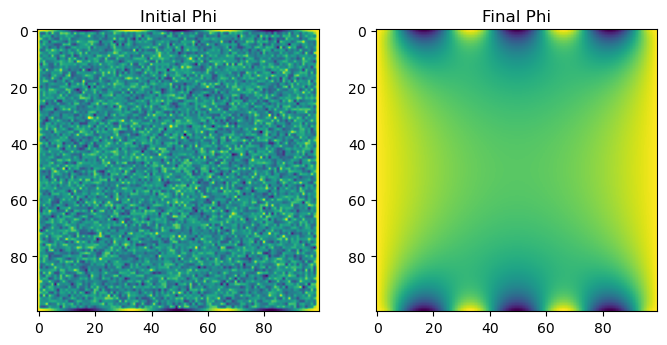

In [202]:
#Let's keep an original copy of Phi to Compare with
PhiInit = Phi.copy()

#we will not update the 0-the index or the GRIDSIZE-1th index
#since those are given by the boundary conditions


for Iteration in tqdm(range(100_000)):
    #We will compare to the current Phi state for early stopping
    PreviousPhi = Phi.copy()

    # Its much more efficient to update all vertices simultaneously
    # This is contrary to class where the algorithm was described as iterating
    # through each vertice and updating one at a time
    Phi[1:-1, 1:-1] = 0.25 * (
        PreviousPhi[:-2, 1:-1] +  # Above
        PreviousPhi[2:, 1:-1] +   # Below
        PreviousPhi[1:-1, :-2] +  # Left
        PreviousPhi[1:-1, 2:]     # Right
    )

    #EarlyStopping Criteria:
    #let's break out of this for loop if we aren't updating Phi very much.
    if np.all(np.abs(PreviousPhi - Phi)< 1e-5):
        print("Early Stopping!")
        break
    #the first step of our loop overwrites PreviousPhi with Phi, so we do
    #not need to do so here.

#now visualize Phi against our original copy:

fig = plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
maxi = 5 #max([np.max(Phi),np.max(PhiInit)])
mini = -5 #min([np.min(Phi),np.min(PhiInit)])
plt.imshow(PhiInit,vmax=maxi,vmin=mini)
plt.title('Initial Phi')
plt.subplot(1,2,2)
plt.imshow(Phi,vmax=maxi,vmin=mini)
plt.title("Final Phi")
plt.show()

### Thats pretty fast! But let's compare this to what a PINN can accomplish.

A PINN is a neural network; it uses automatic differentiation libraries to update a parameterized state mapping the grid points to a function. I.e., you our PINN will represent Phi. Our Neural network will also rely upon a state of parameters calls Theta. Theta will be randomly initialized. We will update Theta by learning. We provide an x and y value, and the PINN outputs PHI(x,y,Theta). We will then ask whether PHI(x,y,Theta) satisfies Laplace's equation through taking second order derivatives. If it does not satisfy to our stopping criteria, we will update Theta in a way so that the PINN more closely satisfies Laplace's equation.

In [442]:
import torch
import torch.nn as nn
import torch.optim as optim

# Fourier Feature Mapping
class FourierFeatureMapping(nn.Module):
    def __init__(self, input_dim, mapping_dim, scale=10.0):
        super(FourierFeatureMapping, self).__init__()
        self.B = torch.randn((input_dim, mapping_dim)) * scale

    def forward(self, x):
        # Apply Fourier feature mapping
        x_proj = 2.0 * torch.pi * x @ self.B  # Linear projection
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)  # Sin and Cos features

# Neural Network with Fourier Features
class FourierPINN(nn.Module):
    def __init__(self, input_dim, fourier_dim, hidden_dim, output_dim, num_layers):
        super(FourierPINN, self).__init__()
        self.fourier_features = FourierFeatureMapping(input_dim, fourier_dim)
        self.mlp = nn.Sequential(
            nn.Linear(2 * fourier_dim, hidden_dim),
            nn.Tanh(),
            *[
                nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.Tanh())
                for _ in range(num_layers - 1)
            ],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x_mapped = self.fourier_features(x)
        return self.mlp(x_mapped)*5


In [443]:
#initialize the model
model = FourierPINN(2,32,256,1,3)

#and the optimizer
opt = optim.Adam(model.parameters(),lr=5e-4)

#We will also use an MSE for the boundary value constraints.
MSELoss = torch.nn.MSELoss()

#place the model onto the selected device.
model.to(DEVICE)

FourierPINN(
  (fourier_features): FourierFeatureMapping()
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): Tanh()
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Tanh()
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [444]:
#Grab a copy of the untrained networks' outputs to plot

#create a vector with all possible grid points so that I can evaluate the model.
all_points = []
for i in range(0,GRIDSIZE):
    for j in range(0,GRIDSIZE):
        all_points.append(np.array([i,j]))
all_points = np.array(all_points).astype(np.float32) / (GRIDSIZE-1)
all_points = torch.tensor(all_points)

#Evaluate the model on these points
PHI_PINN_init = model(all_points)
PHI_PINN_init = PHI_PINN_init[:,0].detach().cpu().numpy()

#place these into the grid.
PhiPINN_init = PhiInit.copy()
k=0
for i in range(0,GRIDSIZE):
    for j in range(0,GRIDSIZE):
        PhiPINN_init[i,j] = PHI_PINN_init[k]
        k+=1

In [439]:
for epoch in tqdm(range(1000)):
    # We need to sample points randomly from the distribution of indices
    x = torch.rand((640, 2), dtype=torch.float32)
    
    #Now we need to dope in boundary conditions
    x[0:80,0] = 0.0
    x[80:160,1] = 0.0
    x[160:240:,0] = 1.0
    x[240:320,1] = 1.0

    #now set to requires grad.
    x.requires_grad = True
    #place the data onto the selected device
    x = x.to(DEVICE)
    # Forward pass
    output = model(x)

    # First derivative (gradient) w.r.t. the [0]th and [1]th inputs
    grad_1st = torch.autograd.grad(
        outputs=output, inputs=x, grad_outputs=torch.ones_like(output), create_graph=True
    )[0]

    # Second derivative w.r.t. the [0]th input
    grad_2nd_0 = torch.autograd.grad(
        outputs=grad_1st[:, 0], inputs=x, grad_outputs=torch.ones_like(grad_1st[:, 0]), create_graph=True
    )[0][:, 0]

    # Second derivative w.r.t. the [1]th input
    grad_2nd_1 = torch.autograd.grad(
        outputs=grad_1st[:, 1], inputs=x, grad_outputs=torch.ones_like(grad_1st[:, 1]), create_graph=True
    )[0][:, 1]

    # Now use this to compute a penalty based on the absolute value of the second derivatives.
    # Connect to model parameters explicitly:
    laplace_residual = grad_2nd_0 + grad_2nd_1 # should be zero. Since sparse, use L1 loss.
    loss = torch.sum(torch.abs(laplace_residual))

    #If the sample includes our boundary conditions, we should also constrain the model to obey them:
    #if input is along x=0:
    MASK = x[:,0] == 0

    B_WEIGHT=0.01
    if torch.any(MASK):
        loss+= 10*B_WEIGHT*MSELoss(output[MASK,0],x_0_boundary_torch(x[MASK,0],x[MASK,1]))
    
    #if input is along y=0
    MASK = x[:,1] == 0
    if torch.any(MASK):
        loss+= B_WEIGHT*MSELoss(output[MASK,0],y_0_boundary_torch(x[MASK,0],x[MASK,1]))

    #if input is along x=GRIDSIZE-1
    MASK = x[:,0] == 1
    if torch.any(MASK):
        loss+= 10*B_WEIGHT*MSELoss(output[MASK,0],x_gridsize_boundary_torch(x[MASK,0],x[MASK,1]))

    #if input is along y=GRIDSIZE-1
    MASK = x[:,1] == 1
    if torch.any(MASK):
        loss+= B_WEIGHT*MSELoss(output[MASK,0],x_gridsize_boundary_torch(x[MASK,0],x[MASK,1]))

    # Ensure the gradients are zero prior to filling gradient buffers
    opt.zero_grad()
    # Backpropagate the loss to the weights
    loss.backward()
    #clip the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    opt.step()

100%|██████████| 1000/1000 [00:31<00:00, 31.82it/s]


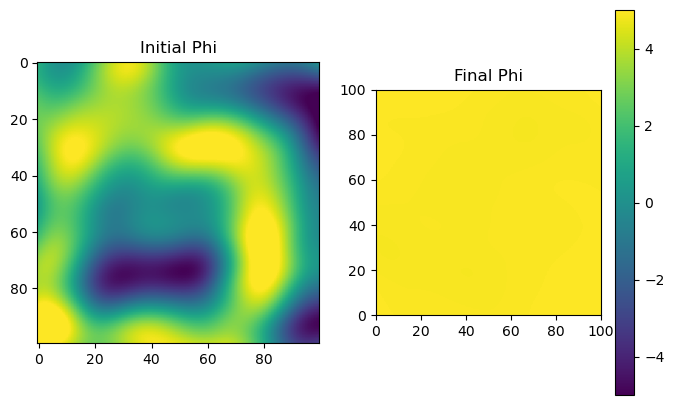

In [440]:
#Evaluate the model on these points
PHI_PINN = model(all_points)
PHI_PINN = PHI_PINN[:,0].detach().cpu().numpy()

#place these into the grid.
PhiPINN = PhiInit.copy()
k=0
for i in range(0,GRIDSIZE):
    for j in range(0,GRIDSIZE):
        PhiPINN[i,j] = PHI_PINN[k]
        k+=1

fig = plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
maxi = 5 
mini = -5 
plt.imshow(PhiPINN_init,vmax=maxi,vmin=mini)
plt.title('Initial Phi')
plt.subplot(1,2,2)
plt.imshow(PhiPINN,vmax=maxi,vmin=mini)
plt.title("Final Phi")
positions = x.detach().cpu().numpy()
#plt.plot(GRIDSIZE*positions[:,0],GRIDSIZE*positions[:,1],'r.')
plt.xlim(0,GRIDSIZE)
plt.ylim(0,GRIDSIZE)
plt.colorbar()
plt.show()